In [3]:
# Fix for KMeans UserWarning on Windows
import os
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Data Collection for ML mini project (Responses) - Form Responses 1.csv')

# Find the relevant columns using a robust substring search to handle messy names
def find_col(substring, columns):
    """Find a column name that contains a specific substring."""
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

relevant_cols = [
    find_col('books read past year', df.columns),
    find_col('reads books', df.columns),
    find_col('book genre top 1', df.columns),
    find_col('screen time', df.columns),
    find_col('binge frequency', df.columns)
]

# Create a clean DataFrame with the selected columns
df_final = df[relevant_cols].copy()

# Rename the columns for easier use
df_final.rename(columns={
    relevant_cols[0]: 'books_read_past_year',
    relevant_cols[1]: 'reads_books',
    relevant_cols[2]: 'book_genre_top1',
    relevant_cols[3]: 'screen_time_movies_series_hours_per_week',
    relevant_cols[4]: 'binge_freq_per_week'
}, inplace=True)

# Data Cleaning and Type Conversion
# Convert numerical columns to a numeric type, coercing errors to handle non-numeric values
df_final['books_read_past_year'] = pd.to_numeric(df_final['books_read_past_year'].astype(str).str.strip(), errors='coerce')
df_final['screen_time_movies_series_hours_per_week'] = pd.to_numeric(df_final['screen_time_movies_series_hours_per_week'].astype(str).str.strip(), errors='coerce')

# Fill any NaN values (from the coercion) with 0
df_final.fillna(0, inplace=True)

# Feature Engineering: Create the reading-to-screen ratio
df_final['reading_to_screen_ratio'] = df_final['books_read_past_year'] / (df_final['screen_time_movies_series_hours_per_week'] + 1e-6)

# Separate features for the pipeline
numerical_features = ['books_read_past_year', 'screen_time_movies_series_hours_per_week', 
                      'binge_freq_per_week', 'reading_to_screen_ratio']
categorical_features = ['reads_books', 'book_genre_top1']

# Set up the preprocessing pipeline for scaling and one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit and transform the data
X = preprocessor.fit_transform(df_final)

# Display the final DataFrame information and first few rows for verification
print(df_final.info())
print(df_final.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 6 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   books_read_past_year                      111 non-null    float64
 1   reads_books                               111 non-null    object 
 2   book_genre_top1                           111 non-null    object 
 3   screen_time_movies_series_hours_per_week  111 non-null    float64
 4   binge_freq_per_week                       111 non-null    int64  
 5   reading_to_screen_ratio                   111 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 5.3+ KB
None
   books_read_past_year reads_books book_genre_top1  \
0                   0.0          No       Self-Help   
1                   2.0   Sometimes         Fiction   
2                   5.0   Sometimes         Fiction   
3                   5.0   Sometimes      

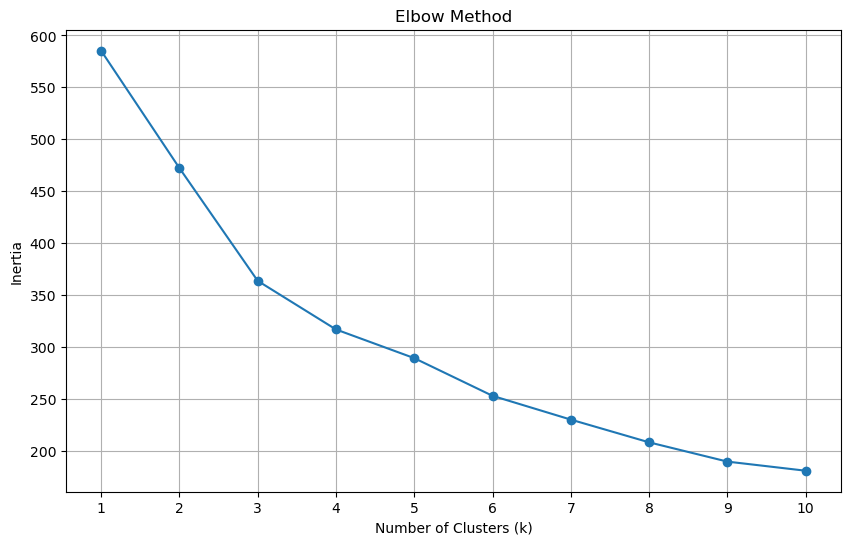

In [4]:
# Use the Elbow Method to determine the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

# Based on the Elbow plot, choose the optimal number of clusters (e.g., k=3)
optimal_k = 3

Final Silhouette Score: 0.2758
Final Davies-Bouldin Index: 1.1872


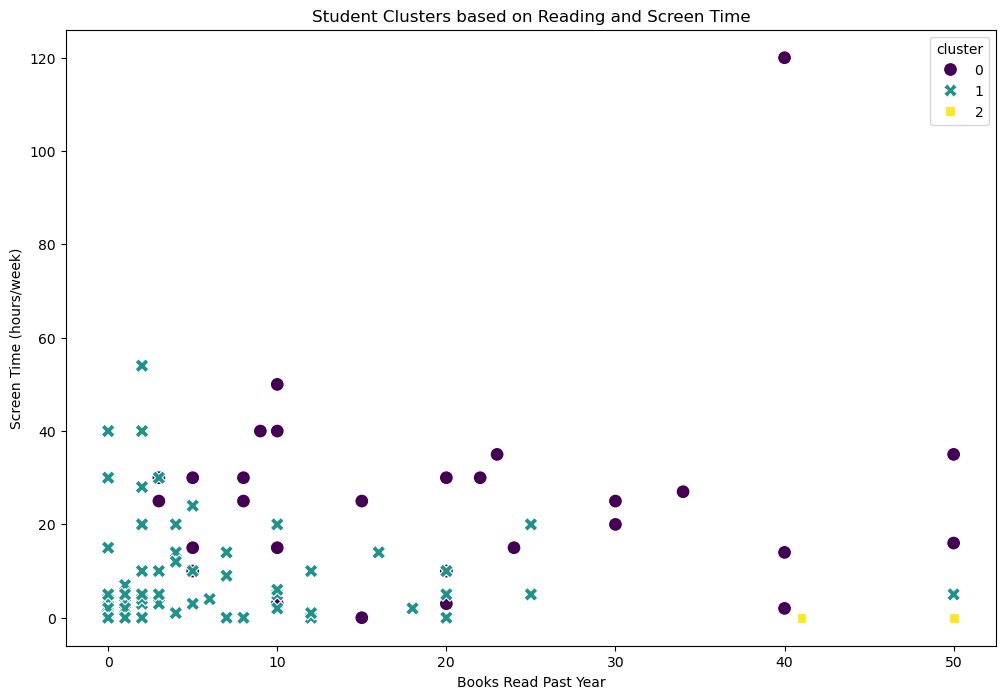


Cluster Archetypes (Means of each feature per cluster):
   books_read_past_year  screen_time_movies_series_hours_per_week  \
0                 19.97                                     25.86   
1                  6.08                                      9.91   
2                 45.50                                      0.00   

   binge_freq_per_week  reading_to_screen_ratio  reads_books_No  \
0                 5.03                517243.16            0.10   
1                 1.87                800000.97            0.12   
2                 0.00              45500000.00            0.00   

   reads_books_Regularly  reads_books_Sometimes  book_genre_top1_Biography  \
0                   0.38                   0.52                       0.03   
1                   0.18                   0.70                       0.11   
2                   0.50                   0.50                       0.00   

   book_genre_top1_Fantasy  book_genre_top1_Fiction  \
0                     0.07   

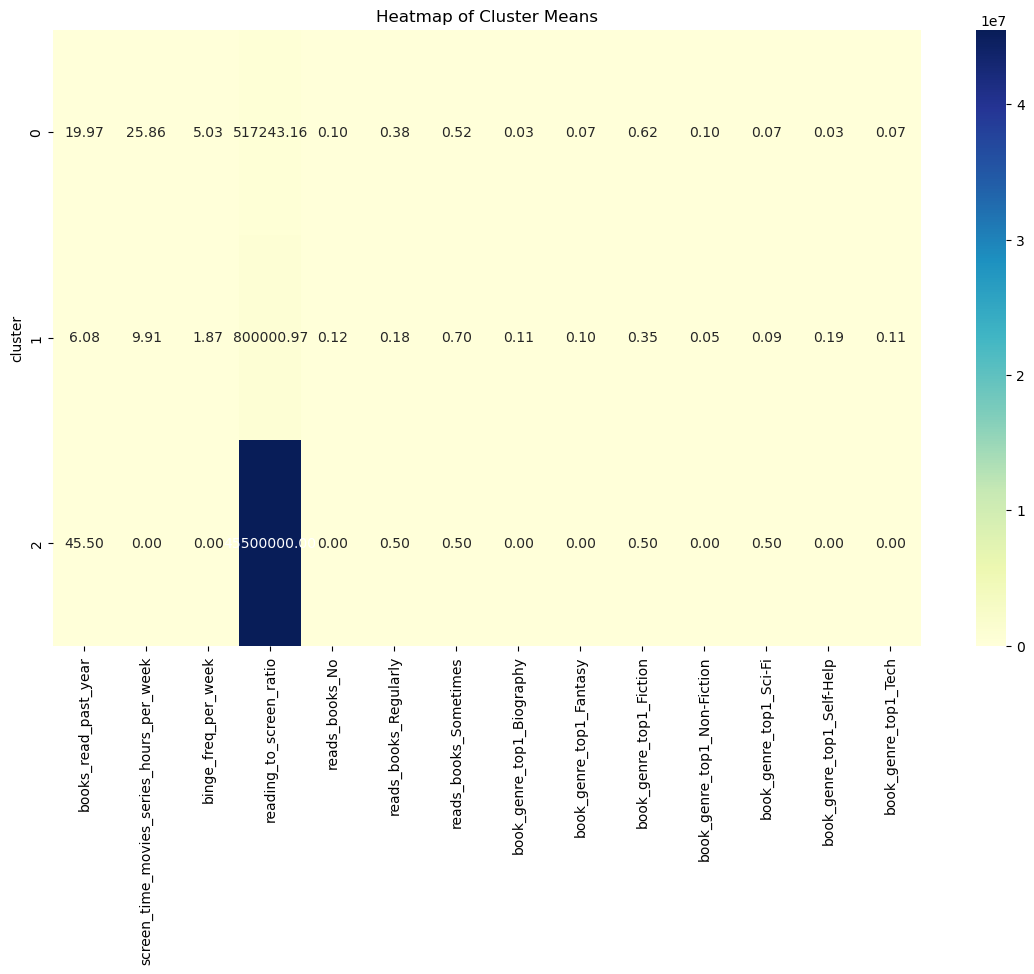


Cluster sizes:
cluster
1    80
0    29
2     2
Name: count, dtype: int64


In [5]:
# Train the final K-Means model with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_final['cluster'] = kmeans.fit_predict(X)

# Evaluate the final model's performance
silhouette = silhouette_score(X, df_final['cluster'])
davies_bouldin = davies_bouldin_score(X, df_final['cluster'])
print(f"Final Silhouette Score: {silhouette:.4f}")
print(f"Final Davies-Bouldin Index: {davies_bouldin:.4f}")

# Visualize the clusters using a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='books_read_past_year', y='screen_time_movies_series_hours_per_week', 
                hue='cluster', data=df_final, palette='viridis', style='cluster', s=100)
plt.title('Student Clusters based on Reading and Screen Time')
plt.xlabel('Books Read Past Year')
plt.ylabel('Screen Time (hours/week)')
plt.show()

# Analyze cluster centers to understand the archetypes
# Create a DataFrame of the cluster centers
cluster_centers_numerical = pd.DataFrame(
    preprocessor.named_transformers_['num'].inverse_transform(kmeans.cluster_centers_[:, :len(numerical_features)]),
    columns=numerical_features
).round(2)

categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
cluster_centers_categorical = pd.DataFrame(
    kmeans.cluster_centers_[:, len(numerical_features):],
    columns=categorical_feature_names
).round(2)

cluster_centers_df = pd.concat([cluster_centers_numerical, cluster_centers_categorical], axis=1)
cluster_centers_df['cluster'] = cluster_centers_df.index
print("\nCluster Archetypes (Means of each feature per cluster):")
print(cluster_centers_df)

# Visualize cluster means with a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_centers_df.set_index('cluster'), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Heatmap of Cluster Means')
plt.show()

print("\nCluster sizes:")
print(df_final['cluster'].value_counts())